Define Basic Parameter

In [ ]:
import requests
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# Enter the latitude and longitude for the location you want to query.
# The script will use these coordinates to fetch the corresponding Micro-Watershed (MWS) ID,
# and then retrieve the data associated with that specific microwatershed.
25.152227367955156, 75.10907576894641
latitude = "25.152227367955156"
longitude  = " 75.10907576894641"

#  Base URL for the CoreStack  API end point
base_url = 'https://geoserver.core-stack.org/api/v1/'

# Endpoint to retrieve the Micro-Watershed (MWS) ID using latitude and longitude
lat_long_mws_api_endpoint = 'get_mwsid_by_latlon/'

# Endpoint to retrieve detailed data for a given Micro-Watershed (MWS) ID
mws_data_api_endpoint = 'get_tehsil_data/'

# Add your API key here.
# You can generate an API key by logging into https://dashboard.core-stack.org with an Organization Admin account.
# Only Org Admins have permission to generate API keys.
# If you are not an Org Admin, please contact your admin to obtain access.
Api_key = 'rBKKRCKl.jsfeUjArYxscYFJZf4FY0L7NuddaSp5u'

In [ ]:
# Define the HTTP request headers with the API key
headers = {
    "X-API-Key": Api_key
}

# Define the query parameters to be sent in the API request

params = {
    "latitude": latitude,
    "longitude": longitude
}

# Construct the full API URL by combining base URL and endpoint
mws_lat_long_api_url = f"{base_url}{lat_long_mws_api_endpoint}"


# Make the GET request with headers and parameters
response = requests.get(mws_lat_long_api_url, params=params, headers=headers)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse JSON response data
    response_data_mws_lat_long = response.json()
    # You can now work with 'response_data_mws_lat_long'
    print("API call successful. Data received.")
else:
    # Handle errors - print status code and response text for debugging
    print(f"API call failed with status code: {response.status_code}")
    print("Response content:", response.text)
    # Optional: you can raise an exception or handle retries here





API call successful. Data received.


In [ ]:
def build_query_params_from_lat_long_api(mws_lat_long_response):
    """
    Extracts relevant query parameters from the MWS lat-long API response
    and returns them in a dictionary format suitable for further API calls.

    Args:
        mws_lat_long_response (dict): Response JSON from the lat-long API containing location info.

    Returns:
        dict: A dictionary with keys 'state', 'district', 'tehsil', and 'mws_id'.
    """
    d = {}
    print(mws_lat_long_response)
    # Extract state name from the API response
    d['state'] = mws_lat_long_response['State']

    # Extract district name from the API response
    d['district'] = mws_lat_long_response['District']

    # Extract tehsil (sub-district) name from the API response
    d['tehsil'] = mws_lat_long_response['Tehsil']

    # Extract unique MWS identifier
    d['mws_id'] = mws_lat_long_response['uid']

    return d


In [ ]:
# Build query parameters from the previous API response
param2 = build_query_params_from_lat_long_api(response_data_mws_lat_long)

# Construct the full URL for the MWS data API endpoint
mws_data_url = f"{base_url}{mws_data_api_endpoint}"

# Make the GET request with the constructed parameters and headers
print(param2)
response = requests.get(mws_data_url, params=param2, headers=headers)

print(response.json())
# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response and extract the hydrological annual data

    ci_data = response.json().get('croppingIntensity_annual', [])
    print (ci_data)
    ci_data = ci_data[0]
    if ci_data:
        plot_data = ci_data
    else:
        print("No hydrological data found in response.")
else:
    # Print error information if the request failed
    print(f"Failed to retrieve data, status code: {response.status_code}")
    print("Response content:", response.text)

raw_data = response.json()

{'State': 'RAJASTHAN', 'District': 'BHILWARA', 'Tehsil': 'MANDALGARH', 'uid': '12_106205'}
{'state': 'RAJASTHAN', 'district': 'BHILWARA', 'tehsil': 'MANDALGARH', 'mws_id': '12_106205'}
{'aquifer_vector': [{'uid': '12_100174', 'area_in_ha': 3182.47, 'aquifer_class': 'Hard Rock', 'principle_aq_alluvium_percent': 0.0, 'principle_aq_banded gneissic complex_percent': 0.0, 'principle_aq_basalt_percent': 0, 'principle_aq_charnockite_percent': 0, 'principle_aq_gneiss_percent': 24.65, 'principle_aq_granite_percent': 0.0, 'principle_aq_intrusive_percent': 21.95, 'principle_aq_khondalite_percent': 0, 'principle_aq_laterite_percent': 0, 'principle_aq_limestone_percent': 0, 'principle_aq_none_percent': 11.0, 'principle_aq_quartzite_percent': 14.7, 'principle_aq_sandstone_percent': 0, 'principle_aq_schist_percent': 0.0, 'principle_aq_shale_percent': 27.7}, {'uid': '12_101214', 'area_in_ha': 752.09, 'aquifer_class': 'Hard Rock', 'principle_aq_alluvium_percent': 0.0, 'principle_aq_banded gneissic comp

In [ ]:
def plot_ci(data):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Extract years dynamically (pattern: single_cropped_area_in_ha_YYYY-YYYY)
    years = sorted({
        key.split('_')[-1]
        for key in data
        if key.startswith('single_cropped_area_in_ha_')
    })

    rows = []
    for year in years:
        single = data.get(f'single_cropped_area_in_ha_{year}', 0)
        double = data.get(f'doubly_cropped_area_in_ha_{year}', 0)
        triple = data.get(f'triply_cropped_area_in_ha_{year}', 0)

        total = single + double + triple

        # avoid division by zero
        if total == 0:
            single_pct = double_pct = triple_pct = 0
        else:
            single_pct = single / total * 100
            double_pct = double / total * 100
            triple_pct = triple / total * 100

        rows.append({
            "Year": year,
            "Single": single_pct,
            "Double": double_pct,
            "Triple": triple_pct
        })

    # Create DataFrame
    df = pd.DataFrame(rows)

    # Plot stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(df["Year"], df["Single"], label="Single Cropped")
    ax.bar(df["Year"], df["Double"], bottom=df["Single"], label="Double Cropped")
    ax.bar(df["Year"], df["Triple"], bottom=df["Single"] + df["Double"], label="Triple Cropped")

    ax.set_ylabel("Percentage (%)")
    ax.set_title("Cropping Intensity Over the Years")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


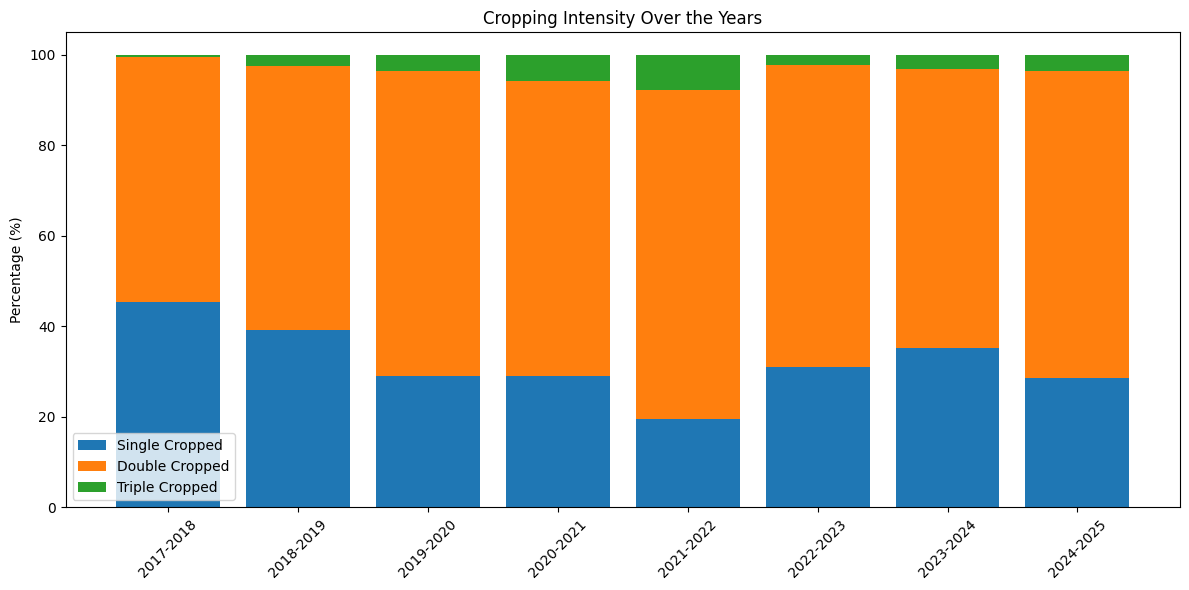

In [ ]:
plot_ci(plot_data)